In [3]:
import pandas as pd
import numpy as np
from gurobipy import *
import random
import itertools
import time 
import pickle as pkl 


# Parameters
teams = ["Adelaide Crows", 
         "Brisbane Lions", 
         "Carlton Blues", 
         "Collingwood Magpies",
         "Essendon Bombers", 
         "Fremantle Dockers", 
         "Geelong Cats", 
         "Gold Coast Suns",
         "Greater Western Sydney Giants", 
         "Hawthorn Hawks", 
         "Melbourne Demons",
         "North Melbourne Kangaroos", 
         "Port Adelaide Power",
         "Richmond Tigers",
         "St Kilda Saints",
         "Sydney Swans",
         "West Coast Eagles",
         "Western Bulldogs"]

team_numbers = {team: number for number, team in enumerate(sorted(teams), start=0)}

locations = ['VIC','NSW','SA','WA','QLD']

location_numbers = {location: number for number, location in enumerate(sorted(locations), start=0)}

home_locations = ['SA','QLD','VIC','VIC','VIC','WA','VIC','QLD','NSW','VIC',
                          'VIC','VIC','SA','VIC','VIC','NSW','WA','VIC']

ranking = [10,2,5,1,11,14,12,15,7,16,4,17,3,13,6,8,18,9] # 2023 pre-finals rankings

team_fans = [60,45,93,102,79,61,81,20,33,72,68,50,60,100,58,63,100,55] # 2023 number of members, in 000's

wins = [11,17,13.5,18,11,10,10.5,9,13,7,16,3,17,10.5,13,12.5,3,12]

stadiums = ['MCG','Marvel','GMHBA','Adelaide Oval','Optus','Gabba','HBS','SCG','Giants']

stadium_numbers = {stadium: number for number, stadium in enumerate(sorted(stadiums), start=0)}

stadium_locations = ['VIC','VIC','VIC','SA','WA','QLD','QLD','NSW','NSW']

home_stadiums = [['Adelaide Oval'],['Gabba'],['MCG','Marvel'],['MCG','Marvel'],['MCG','Marvel'],['Optus'],['GMHBA'],
                 ['HBS'],['Giants'],['MCG'],['MCG'],['Marvel'],['Adelaide Oval'],
                 ['MCG'],['Marvel'],['SCG'],['Optus'],['Marvel']]

home_location_stadiums = [[] for i in range(len(teams))]
for i in range(len(teams)):
    for j in range(len(stadiums)):
        if stadium_locations[j] == home_locations[i]:
            home_location_stadiums[i].append(stadiums[j])

stadium_size = [100,53,40,54,60,39,27,47,24] # Stadium sizes in 000's

rivals = [['Port Adelaide Power'],
          ['Gold Coast Suns','Collingwood Magpies'], # From wikipedia
          ['Essendon Bombers','Richmond Tigers','Collingwood Magpies', 'Fremantle Dockers'],
          ['Carlton Blues','Essendon Bombers','Brisbane Lions','Melbourne Demons','Richmond Tigers','Geelong Cats',
           'Hawthorn Hawks', 'West Coast Eagles','Port Adelaide Power'],
          ['Carlton Blues','Collingwood Magpies','Richmond Tigers','Hawthorn Hawks','North Melbourne Kangaroos'],
          ['Carlton Blues','West Coast Eagles'],
          ['Collingwood Magpies','Hawthorn Hawks'],
          ['Brisbane Lions'],
          ['Sydney Swans','Western Bulldogs'],
          ['Hawthorn Hawks','Geelong Cats','Essendon Bombers', 'North Melbourne Kangaroos'],
          ['Collingwood Magpies'],
          ['Essendon Bombers','Hawthorn Hawks'],
          ['Adelaide Crows','Collingwood Magpies'],
          ['Carlton Blues','Collingwood Magpies','Essendon Bombers'],
          ['Sydney Swans'],
          ['West Coast Eagles','St Kilda Saints','Greater Western Sydney Giants','Hawthorn Hawks'],
          ['Fremantle Dockers','Sydney Swans','Collingwood Magpies'],
          ['Greater Western Sydney Giants']]

rivals_num = [[team_numbers[i] for i in rivals[j]] for j in range(len(rivals))]

timeslots = [i for i in range(7)]
timeslot_values = [10,13,5,6,11,5,4] # Change later according to attendances
timeslot_names = ['Thursday Night','Friday Night','Saturday Afternoon','Saturday Evening',
                  'Saturday Night','Sunday Afternoon','Sunday Evening']

Ts = range(len(teams))
Ss = range(len(stadiums))
timeslots = range(7)
rounds = range(22)

# Decision Variables
fixture_matrix = [[[[[0 for r in rounds] for t in timeslots] for s in Ss] for j in Ts] for i in Ts]

# Attractiveness Function Parameters, adjust them as needed
alpha = 1.0
beta = 1.0
gamma = 1.0
sigma = 1.0
xi = 1.0

def attractiveness(i, j, s, t, r):
    score = 1
    if r == 0:
        score *= 4
    elif r == 1:
        score *= 2
    elif r == 21:
        score *= 2
    
    if j in rivals[i]:
        score *= 1+alpha
    
    score /= np.sqrt(1+abs(ranking[i]-ranking[j]))
    score  /= np.sqrt(ranking[i]+ranking[j])
    
    if stadium_locations[s] == home_locations[j]:
        score *= (1+beta)
        
    score *= np.sqrt(stadium_size[s])
    score *= np.sqrt(team_fans[i]+0.5*team_fans[j])
    
    score *= timeslot_values[t]
    
    return score


def probability_win(i, j, s):
    probability = wins[i]/(wins[i]+wins[j])
    if stadiums[s] not in home_location_stadiums[j]:
        probability += (1-probability)/2.5
    elif stadiums[s] not in home_stadiums[j]:
        probability += (1-probability)/4
    else:
        probability += (1-probability)/10
        
    return probability

def expected_win_variance(fixture):
    results = []
    expected_wins = [0]*18
    for r in rounds:
        for i in Ts:
            for j in Ts:
                for s in Ss:
                    for t in timeslots:
                        expected_wins[i] += probability_win(i, j, s)*fixture[i][j][s][t][r]
                        expected_wins[i] += (1-probability_win(j, i, s))*fixture[j][i][s][t][r]
        
        results.append(np.var(expected_wins))

    return sum((i+1)*results[i] for i in range(len(results)))
    
def feasibility(fixture):
    violated = 0
    critical = 0
    
    for i in Ts: # Each team plays once a week
        for r in rounds:
            critical += abs(sum(fixture[i][j][s][t][r] + fixture[j][i][s][t][r] for j in Ts for s in Ss for t in timeslots)-1)
            
    
    for i in Ts:
        critical += abs(sum(fixture[i][j][stadium_numbers[s]][t][r] for j in Ts for s in home_stadiums[i] 
                                 for t in timeslots for r in rounds)-11)
    
    
    for i in Ts:
        critical += sum(fixture[i, i, s, t, r] for s in Ss for t in timeslots for r in rounds)
        
        for j in Ts:
            if i != j:
                violated += max(sum(fixture[i][j][s][t][r] for s in Ss for t in timeslots for r in rounds)-1,0)
                violated += max(1-sum(fixture[i][j][s][t][r] + fixture[j][i][s][t][r] for s in Ss for t in timeslots for r in rounds),0)
                
                
    for i in Ts:
        for r in rounds[:-1]:
            violated += max(0,sum(fixture[i][j][s][t][r] + fixture[j][i][s][t][r] for j in Ts for s in Ss for t in [5,6])+ 
                            sum(fixture[i, j, s, t, r+1]+fixture[j, i, s, t, r+1] for j in Ts for s in Ss for t in [0]) - 1)
            
    
    # Three games in a row outside home location
    for i in Ts:
        for r in rounds[:-2]:
            violated += max(0,1-sum(fixture[j][i][stadium_numbers[s]][t][r_]+fixture[i][j][stadium_numbers[s]][t][r_] for j in Ts for s in home_location_stadiums[i] 
                                 for t in timeslots for r_ in range(r,r+3)))
       
    # Four away games in a row
    for i in Ts:
        for r in rounds[:-3]:
            violated += max(0,1-sum(fixture[i, j, s, t, r_] for j in Ts for s in Ss for t in timeslots for r_ in range(r,r+4)))
    
    
    # Constraint 7: 2+ games in one day in the same stadium
    for r in rounds:
        for s in Ss:
            
            violated += max(0,sum(fixture[i][j][s][t][r] for i in Ts for j in Ts for t in [5, 6])-1)
            
            violated += max(0,sum(fixture[i][j][s][t][r] for i in Ts for j in Ts for t in [2, 3, 4])-1)
            
            for t in [0,1]:
                violated += max(0,sum(fixture[i][j][s][t][r] for i in Ts for j in Ts)-1)
    
    
    # Constraint: No more than two games in any timeslot, and only one on Thursday and Friday night, at least one in each
    for r in rounds:
        
        for t in [2,3,4,5,6]:
            violated += max(0,1-sum(fixture[i][j][s][t][r] for i in Ts for j in Ts for s in Ss)) # At least one game each timeslot
            violated += max(0,sum(fixture[i][j][s][t][r] for i in Ts for j in Ts for s in Ss)-2)
        
        for t in [0,1]:
            violated += max(0,sum(fixture[i][j][s][t][r] for i in Ts for j in Ts for s in Ss)-1) # One game
            
            
    return violated, critical



def fixture_attractiveness(fixture,max_value,violated_factor,critical_factor,equality_factor):
    total_score = 0
    
    for r in rounds:
        for t in timeslots:
            value = 0
            for i in Ts:
                for j in Ts:
                    for s in Ss:
                        value += attractiveness(i, j, s, t, r)*fixture[i][j][s][t][r]
                            
            total_score += min(max_value,value)
            
    violated, critical = feasibility(fixture)
    equality = equality_factor*expected_win_variance(fixture)
    
    return total_score - violated_factor*violated - critical_factor*critical - equality

def objective_value(fixture, gen_count):

    violated, critical = feasibility(fixture)
    
    violated_penalty = 2*10**4
    critical_penalty = 10**6
    
    # print('Violated Constraints: ', violated, critical)
    # print('Factors: ', violated_penalty, critical_penalty)

    objective_value = - violated_penalty*violated - critical_penalty*critical + fixture_attractiveness(fixture, 2*10^4, critical_penalty, violated_penalty, 10^3) 

    return objective_value


[[[[[0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    ...
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]]

   [[0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    ...
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]]

   [[0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    ...
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]]

   ...

   [[0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    ...
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]]

   [[0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    ...
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]]

   [[0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    ...
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]]]


  [[[0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    ...
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0]
    [0 0 0 ... 0 0 0

In [4]:
print(objective_value(soln[0][0]))

-394739807.3909389


[-3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08
 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08 -3.87386807e+08]


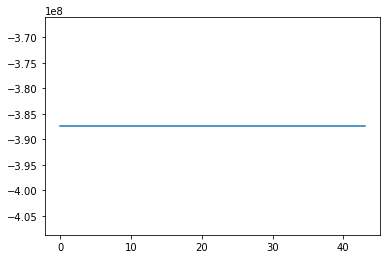

In [ ]:
import matplotlib.pyplot as plt

soln = np.load('solutions\GA\GA_soln_improved.npy', allow_pickle=True)
num_gen = soln[1]
progress = np.load("solutions\GA\GA_soln_improved_progress.npy", allow_pickle=True)
# obj_prog = []
# for i in progress:
#     obj_prog.append(i[1])

# print(obj_prog)
# plt.plot(obj_prog)

print(progress)
plt.plot(progress)

In [6]:
MIP_soln1 = np.load('initialPopulation/MILP_Fixture_10000_2023.npy')

objective = objective_value(MIP_soln1)
violated, critical = feasibility(MIP_soln1)

print(objective)
print(violated, critical)

-1746240000.0
1118 594
